# Notebook for modeling taxi dropoff z-score based on twitter during sandy.

In [1]:
%matplotlib inline
import sys
import os
sys.path.append(os.path.abspath('../'))

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats
import seaborn as sns
sns.set()
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf

from twitterinfrastructure.tools import boxcox_backtransform, \
    output, query
import twitterinfrastructure.analysis as asys
import twitterinfrastructure.analyze_nyctlc as taxi
import twitterinfrastructure.twitter_sandy as ts

import importlib
importlib.reload(asys)
importlib.reload(taxi)
importlib.reload(ts)

#os.chdir('../')
print(os.getcwd())

matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **{'family': "serif"})
params = {'text.latex.preamble': [r'\usepackage{siunitx}', 
                                  r'\usepackage{amsmath}']}
plt.rcParams.update(params)
sns.set_context('paper')
# sns.set_context('talk')
sns.set_style('darkgrid')

C:\dev\research\socialsensing\notebooks


## Load data hourly taxi zone pace and dropoff z-scores and sandy tweet data.

Data is grouped by hour and zone. Loading takes ~30 seconds.

In [4]:
trip_count_filter = 5   # by hour
tweet_count_filter = 5  # by day
# db_path = 'data/processed/nyctlc-2012.db'
db_path = 'E:/Work/projects/twitterinfrastructure/data/processed/nyctlc-2012.db'

startdate = pd.Timestamp('2012-10-28 00:00:00', 
                         tz='America/New_York')  # inclusive
enddate = pd.Timestamp('2012-11-03 00:00:00', 
                       tz='America/New_York')  # exclusive

# load taxi dropoff data (filtered by dates, grouped by zone and hour)
df_drop = asys.load_nyctlc_zone_hour(startdate, enddate, 'dropoff', 
                                     trip_count_filter, db_path, verbose=2)

# load normalized sandy-related tweets (filtered by dates, grouped by zone 
# and hour)
df_tweets = ts.query_groupby_hour_norm('tweets_sandy', 'tweets_analysis', 
                                       'location_id', tweet_count_filter, 
                                       startdate=startdate, enddate=enddate, 
                                       verbose=2)

df_tweets = df_tweets.rename(columns={'tweets': 'sandy-tweets', 
                                      'tweets-norm': 'sandy-tweets-norm'})

# combine into one dataframe
df_tweets.index.names = ['location_id', 'datetimeNY']   # temp (merge)
df = pd.merge(df_drop, df_tweets, how='left', left_index=True, 
              right_index=True)

# remove infinite values with nan
df = df.replace([np.inf, -np.inf], np.nan)

# export hourly dataframe to csv
print('Dataframe rows: ' + str(df.shape[0]))
# path = 'data/processed/taxisummary_zone_hour.csv'
# df.to_csv(path, index_label=['zone', 'datetimeNY'])

2019-02-21 15:54:12 : Started query.

2019-02-21 15:54:13 : [min, max] taxi datetimeNY (hourly): [2012-10-28 00:00:00-04:00, 2012-11-02 23:00:00-04:00].

2019-02-21 15:54:13 : [min, max] taxi pace and trips mean z-score (hourly): [-37.8165701074617, 160.71751319680212], [-0.8207678323173992, 23.07142857142857].

2019-02-21 15:54:13 : Started query.

2019-02-21 15:54:13 : Started query.



AttributeError: 'NoneType' object has no attribute 'keys'

In [5]:
df_td.head()

NameError: name 'df_td' is not defined

In [7]:
# print zone counts with nans removed (48: 42, 230: 38, 263: 26 ...)
y1 = 'sandy-tweets-norm'
y2 = 'ztrips-drop'
# y2 = 'zpace-drop'
df_na = df[[y1, y2]].dropna()
counts = df_na.count(level='location_id')[y1]
counts = counts.sort_values(ascending=False)
counts = counts.rename('number of non-nan data points per zone')
print(counts[0:10])
print('')

# create timedelta dataframe (indexed by timedelta from landing)
datetime_ref = pd.Timestamp('2012-10-30 20:00:00', tz='America/New_York')
df_td = df[[y1, y2]]
df_td = asys.index_timedelta(df_td, datetime_ref, 'datetimeNY')

# create time series dataframe (linearly interpolated over the max range of 
# timedeltas for each parameter of each zone, only series with at least 
# min_count data points are included)
min_count = 20
df_ts = asys.create_timeseries(df_td, 'location_id', min_count,
                               write_path='test.csv', verbose=2)

location_id
48     42
230    38
263    26
79     26
181    22
170    21
68     19
255    16
142    15
164    14
Name: number of non-nan data points per zone, dtype: int64

2018-10-04 17:50:59 : skipped zones for having less than 20 data points in original column data: [(1, 'sandy-tweets-norm'), (4, 'sandy-tweets-norm'), (7, 'sandy-tweets-norm'), (9, 'sandy-tweets-norm'), (9, 'ztrips-drop'), (10, 'sandy-tweets-norm'), (11, 'sandy-tweets-norm'), (11, 'ztrips-drop'), (12, 'sandy-tweets-norm'), (13, 'sandy-tweets-norm'), (14, 'sandy-tweets-norm'), (15, 'sandy-tweets-norm'), (15, 'ztrips-drop'), (16, 'sandy-tweets-norm'), (16, 'ztrips-drop'), (17, 'sandy-tweets-norm'), (18, 'sandy-tweets-norm'), (20, 'sandy-tweets-norm'), (20, 'ztrips-drop'), (21, 'sandy-tweets-norm'), (21, 'ztrips-drop'), (22, 'sandy-tweets-norm'), (24, 'sandy-tweets-norm'), (25, 'sandy-tweets-norm'), (26, 'sandy-tweets-norm'), (28, 'sandy-tweets-norm'), (29, 'sandy-tweets-norm'), (29, 'ztrips-drop'), (32, 'sandy-tweets-no

## Analyze scatterplots for timedelta dataframe.

Text(0,0.5,'ztrips-drop')

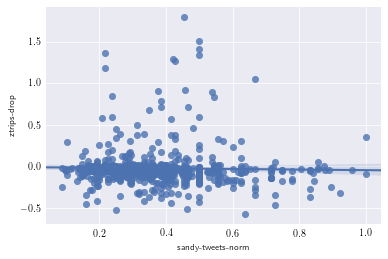

In [8]:
# scatterplot
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=False)
ax = sns.regplot(y1, y2,
                 data=df_td, fit_reg=True,
                 scatter_kws={'marker': 'D', 's': 50},
                 ax=ax)

# axes
ax.tick_params(axis='both', colors='k')
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel(y1)
ax.set_ylabel(y2)

# save
# ax.set_xlabel(r'log($SN_{i,t}$)', color='k', size=12)
# ax.set_ylabel(r'log($\langle | z\textnormal{-drop}_{i,t} | \rangle$)', 
#               color='k', size=12)
# plt.savefig('notebooks/images/report/taxi-totalcorrelation.png', dpi=150, 
#             bbox_inches='tight')

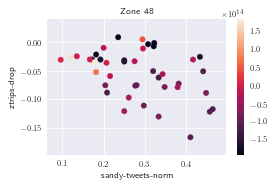

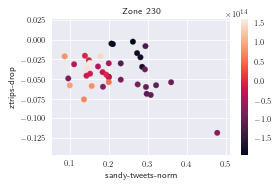

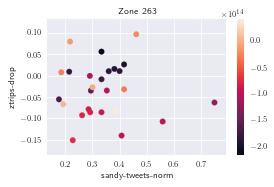

In [9]:
# scatterplot by zone (colored by timedelta)
zones = [48, 230, 263]
# zones = [48]
for zone in zones:
    df_zone = df_td.xs(zone, level=0)
    y1_s = df_zone[y1]
    y2_s = df_zone[y2]

    # scatterplot
    fig, ax = plt.subplots(figsize=(4, 2.5), tight_layout=False)
    sc = ax.scatter(y1_s, y2_s, c=df_zone.index.values)
    plt.colorbar(sc)
    ax.set_xlabel(y1)
    ax.set_ylabel(y2)
    plt.title('Zone {z}'.format(z=zone))

## Analyze time series models. - START HERE

TODO
- look for ways to handle the trend and seaonality/cyclic nature of data (e.g. see [here](https://otexts.org/fpp2/autocorrelation.html))

lambda (box-cox): 6.2871782628019925


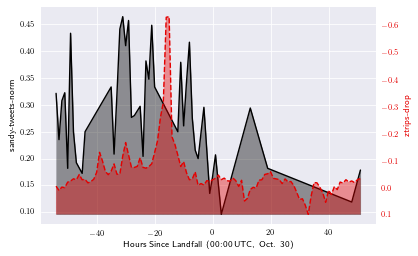

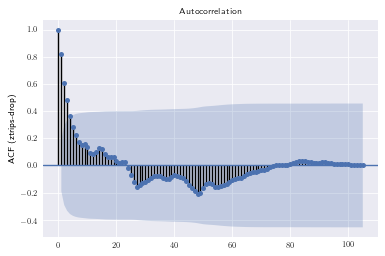

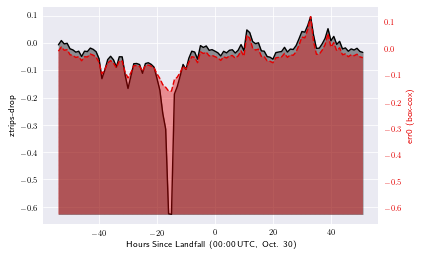

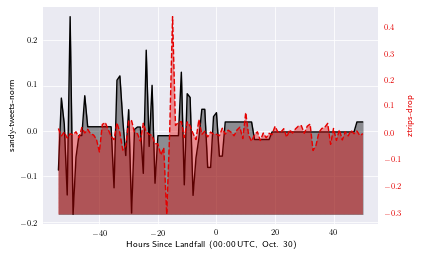

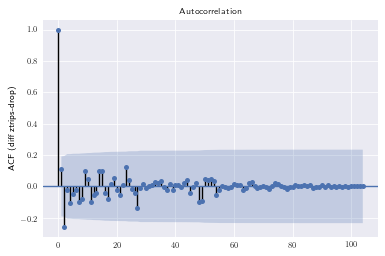

In [10]:
# analyze time series trends
# zones = pd.unique(df_ts.index.get_level_values(level=0))
zones = [48]
for zone in zones:
    # get data
    df_zone = df_ts.xs(zone, level=0).dropna()
    
    # plot tweets and taxi time series - START HERE - WHY IS THE ZTRIPS-DROP 
    # DIFFERENT HERE THAN IN correlation-taxi-twitter.ipynb
    # create figure
    fig, ax1 = plt.subplots(figsize=(6, 4), tight_layout=False)
    ax2 = ax1.twinx()
    ax2.grid(None)
    linestyles = ['-', '--', ':']
    lines = []
    
    # add shaded line plots
    x = [int(td.total_seconds() / 3600) for td in df_zone.index]
    line = ax1.plot(x, df_zone[y1].values, 
                    color='xkcd:black', linestyle=linestyles[0])
    ax1.fill_between(x, y1=list(df_zone[y1].values), y2=min(df_zone[y1].values), 
                     color='xkcd:black', linestyle=linestyles[0], 
                     alpha=0.4)
    lines.append(line[0])
    line = ax2.plot(x, df_zone[y2].values,
                    color='xkcd:red', linestyle=linestyles[1])
    ax2.fill_between(x, y1=df_zone[y2].values, y2=max(df_zone[y2].values),
                     color='xkcd:red', linestyle=linestyles[1], 
                     alpha=0.4)
    lines.append(line[0])
    
    # axes
    ax1.tick_params(axis='both', colors='k')
    ax1.set_xlabel('Hours Since Landfall (00:00 UTC, Oct. 30)', 
                   color='k')
    ax1.set_ylabel(y1, color='k')
    ax2.set_ylabel(y2, color='xkcd:red')
    ax2.tick_params(axis='y', labelcolor='xkcd:red')
    ax2.invert_yaxis()
    # plt.title('Zone {z}'.format(z=zone))
    
    # plot ACF
    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=False)
    plot_acf(df_zone[y2], ax=ax)
    ax.set_ylabel('ACF ({var})'.format(var=y2), color='k')
    
    # plot err0 and err0 with box-cox
    fig, ax1 = plt.subplots(figsize=(6, 4), tight_layout=False)
    ax2 = ax1.twinx()
    ax2.grid(None)
    linestyles = ['-', '--']
    lines = []
    
    # add shaded line plots
    x = [int(td.total_seconds() / 3600) for td in df_zone.index]
    line = ax1.plot(x, df_zone[y2].values, 
                    color='xkcd:black', linestyle=linestyles[0])
    ax1.fill_between(x, y1=list(df_zone[y2].values), 
                     y2=min(df_zone[y2].values), 
                     color='xkcd:black', linestyle=linestyles[0], 
                     alpha=0.4)
    lines.append(line[0])
    vals, lmbda = scipy.stats.boxcox(df_zone[y2].values + 1, lmbda=None)
    line = ax2.plot(x, vals, color='xkcd:red', linestyle=linestyles[1])
    ax2.fill_between(x, y1=vals, y2=min(df_zone[y2].values),
                     color='xkcd:red', linestyle=linestyles[1], 
                     alpha=0.4)
    lines.append(line[0])
    
    # axes
    ax1.tick_params(axis='both', colors='k')
    ax1.set_xlabel('Hours Since Landfall (00:00 UTC, Oct. 30)', 
                   color='k')
    ax1.set_ylabel(y2, color='k')
    ax2.set_ylabel('err0 (box-cox)', color='xkcd:red')
    ax2.tick_params(axis='y', labelcolor='xkcd:red')
    print('lambda (box-cox): {lmbda}'.format(lmbda=lmbda))
    
    # plot differenced tweets and err0 time series
    # create figure
    fig, ax1 = plt.subplots(figsize=(6, 4), tight_layout=False)
    ax2 = ax1.twinx()
    ax2.grid(None)
    linestyles = ['-', '--', ':']
    lines = []
    # add shaded line plots
    x = [int(td.total_seconds() / 3600) for td in df_zone.index]
    y1_vals_diff = np.diff(df_zone[y1].values, 1)
    line = ax1.plot(x[0:-1], y1_vals_diff, 
                    color='xkcd:black', linestyle=linestyles[0])
    ax1.fill_between(x[0:-1], y1=y1_vals_diff, y2=min(y1_vals_diff), 
                     color='xkcd:black', linestyle=linestyles[0], 
                     alpha=0.4)
    
    lines.append(line[0])
    
    y2_vals_diff = np.diff(df_zone[y2].values, 1)
    line = ax2.plot(x[0:-1], y2_vals_diff,
                    color='xkcd:red', linestyle=linestyles[1])
    ax2.fill_between(x[0:-1], y1=y2_vals_diff, y2=min(y2_vals_diff),
                     color='xkcd:red', linestyle=linestyles[1], 
                     alpha=0.4)
    lines.append(line[0])
    # axes
    ax1.tick_params(axis='both', colors='k')
    ax1.set_xlabel('Hours Since Landfall (00:00 UTC, Oct. 30)', 
                   color='k')
    ax1.set_ylabel(y1, color='k')
    ax2.set_ylabel(y2, color='xkcd:red')
    ax2.tick_params(axis='y', labelcolor='xkcd:red')
    # plt.title('Zone {z}'.format(z=zone))
    
    # plot ACF
    fig, ax = plt.subplots(figsize=(6, 4), tight_layout=False)
    plot_acf(y2_vals_diff, ax=ax)
    ax.set_ylabel('ACF (diff {var})'.format(var=y2), color='k')